In [3]:
!pip install wandb tqdm
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import wandb
import numpy as np

In [16]:
class CrossCapsuleAttention(nn.Module):
    def __init__(self, dim, num_heads=8):  # Increased heads from 4 to 8
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        # Enhanced attention components
        self.qkv = nn.Sequential(
            nn.Linear(dim, dim * 3),
            nn.LayerNorm(dim * 3)
        )

        # Added intermediate layer
        self.intermediate = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim)
        )

        self.proj = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(0.1)  # Added dropout
        )

    def forward(self, x):
        B, N, C = x.shape

        # Enhanced attention computation
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        # Scaled dot-product attention with improved numerical stability
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = F.dropout(attn, p=0.1, training=self.training)  # Added attention dropout

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.intermediate(x)  # Added intermediate processing
        x = self.proj(x)
        return x

In [17]:
class Capsule(nn.Module):
    def __init__(self, input_dim, output_dim, temporal=False, num_heads=8):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.temporal = temporal

        # Enhanced primary transformation
        self.transform = nn.Sequential(
            nn.Linear(input_dim, output_dim * 4),  # Wider network
            nn.LayerNorm(output_dim * 4),          # Added normalization
            nn.GELU(),                             # Changed to GELU
            nn.Dropout(0.1),                       # Added dropout
            nn.Linear(output_dim * 4, output_dim * 2),
            nn.LayerNorm(output_dim * 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(output_dim * 2, output_dim)
        )

        # Enhanced self-organizing components
        self.som_centers = nn.Parameter(torch.randn(output_dim, input_dim))
        self.som_scale = nn.Parameter(torch.ones(1))  # Learnable scaling

        # Cross-capsule attention with more heads
        self.attention = CrossCapsuleAttention(output_dim, num_heads)

        # Enhanced temporal components
        if temporal:
            self.temporal_gate = nn.GRU(
                output_dim,
                output_dim,
                num_layers=2,  # Added another layer
                dropout=0.1
            )

        # Enhanced feedback connections
        self.feedback_transform = nn.Sequential(
            nn.Linear(output_dim, input_dim * 2),
            nn.GELU(),
            nn.Linear(input_dim * 2, input_dim)
        )

        # Enhanced projection for contrastive learning
        self.projector = nn.Sequential(
            nn.Linear(output_dim, output_dim * 2),
            nn.LayerNorm(output_dim * 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(output_dim * 2, output_dim * 2),
            nn.LayerNorm(output_dim * 2),
            nn.GELU(),
            nn.Linear(output_dim * 2, output_dim)
        )

        # Added residual connection
        self.residual_projection = nn.Linear(input_dim, output_dim) if input_dim != output_dim else nn.Identity()

    def forward(self, x, other_capsules=None, prev_state=None):
        batch_size = x.shape[0]

        # Primary transformation with residual
        transformed = self.transform(x)
        residual = self.residual_projection(x)

        # Enhanced self-organization
        x_expanded = x.unsqueeze(1)
        centers_expanded = self.som_centers.unsqueeze(0)
        distances = torch.sum((x_expanded - centers_expanded) ** 2, dim=-1)
        distances = distances * self.som_scale  # Learnable scaling

        # Soft assignment with temperature scaling
        assignments = F.softmax(-distances / 0.1, dim=-1)  # Added temperature

        # Combine transformation and self-organization with residual
        output = transformed * assignments + residual

        # Apply cross-capsule attention if other capsules are provided
        if other_capsules is not None:
            all_outputs = torch.stack([output] + other_capsules, dim=1)
            output = output + self.attention(all_outputs)[:, 0]  # Added residual

        # Enhanced temporal processing
        if self.temporal and prev_state is not None:
            temporal_out, new_state = self.temporal_gate(output.unsqueeze(0), prev_state)
            output = output + temporal_out.squeeze(0)  # Added residual
        else:
            new_state = None

        # Generate projection for contrastive learning
        projection = self.projector(output)

        return output, projection, new_state

In [18]:
class HISOC(nn.Module):
    def __init__(self, layer_dims, temporal=False, temperature=0.07):
        super().__init__()
        self.temporal = temporal
        self.temperature = temperature

        # Create capsule layers
        self.capsules = nn.ModuleList([
            Capsule(in_dim, out_dim, temporal=temporal)
            for in_dim, out_dim in zip(layer_dims[:-1], layer_dims[1:])
        ])

        # Energy function components
        self.reconstruction_decoder = nn.Sequential(
            nn.Linear(layer_dims[-1], layer_dims[0]),
            nn.Tanh()
        )

    def contrastive_loss(self, projections, batch_size):
        # Compute similarity matrix
        sim_matrix = torch.mm(projections, projections.t()) / self.temperature

        # Create labels for contrastive learning
        labels = torch.arange(batch_size, device=projections.device)

        # Compute NCE loss
        loss = F.cross_entropy(sim_matrix, labels)
        return loss

    def forward(self, x, prev_states=None):
        batch_size = x.shape[0]

        if prev_states is None and self.temporal:
            prev_states = [None] * len(self.capsules)

        # Forward pass through capsule hierarchy
        current_input = x
        activations = [current_input]
        projections = []
        new_states = []

        for i, capsule in enumerate(self.capsules):
            # Get outputs from other capsules at same level
            other_capsules = [act for j, act in enumerate(activations[1:])
                            if j != i and act.shape[-1] == capsule.output_dim]

            output, projection, new_state = capsule(
                current_input,
                other_capsules if other_capsules else None,
                prev_states[i] if prev_states else None
            )

            activations.append(output)
            projections.append(projection)
            new_states.append(new_state)
            current_input = output

        # Reconstruction for energy function
        reconstruction = self.reconstruction_decoder(activations[-1])

        # Compute energy components
        reconstruction_error = F.mse_loss(reconstruction, x)

        # KL divergence for structured representations
        kl_div = 0
        for act in activations[1:]:
            kl_div += torch.mean(F.kl_div(
                F.log_softmax(act, dim=-1),
                torch.ones_like(act) / act.shape[-1]
            ))

        # Temporal coherence if enabled
        temporal_error = 0
        if self.temporal and len(activations) > 1:
            for act in activations[1:]:
                temporal_error += F.mse_loss(
                    act[:-1],
                    act[1:]
                )

        # Contrastive loss across all projections
        contrastive_losses = []
        for proj in projections:
            contrastive_losses.append(self.contrastive_loss(proj, batch_size))
        contrastive_loss = sum(contrastive_losses) / len(contrastive_losses)

        # Total energy with contrastive component
        energy = (
            reconstruction_error +
            0.1 * kl_div +
            0.1 * temporal_error +
            0.1 * contrastive_loss
        )

        return {
            'activations': activations,
            'projections': projections,
            'reconstruction': reconstruction,
            'energy': energy,
            'contrastive_loss': contrastive_loss,
            'new_states': new_states if self.temporal else None
        }

In [19]:
def train_step(model, optimizer, batch, n_feedback_steps=3):
    optimizer.zero_grad()

    # Initial forward pass
    output = model(batch)
    loss = output['energy']

    loss.backward()
    optimizer.step()

    return {
        'total_loss': loss.item(),
        'contrastive_loss': output['contrastive_loss'].item()
    }

def create_hisoc_model(input_dim=784, hidden_dims=[512, 256, 128], temporal=False):
    layer_dims = [input_dim] + hidden_dims
    model = HISOC(layer_dims, temporal=temporal)
    return model

In [20]:
class HISOCTrainer:
    def __init__(
        self,
        model,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        learning_rate=1e-4,
        batch_size=64,
        num_epochs=50,
        use_wandb=False  # Set to False by default
    ):
        self.model = model.to(device)
        self.device = device
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.use_wandb = use_wandb

        # Initialize optimizer
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )

    def load_mnist_data(self):
        """Load and prepare MNIST dataset"""
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

        # Load training data
        train_dataset = datasets.MNIST(
            './data', train=True, download=True, transform=transform
        )
        self.train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True
        )

        # Load validation data
        val_dataset = datasets.MNIST(
            './data', train=False, download=True, transform=transform
        )
        self.val_loader = DataLoader(
            val_dataset, batch_size=self.batch_size, shuffle=False
        )

    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        total_contrastive_loss = 0

        with tqdm(self.train_loader, desc=f'Epoch {epoch}') as pbar:
            for batch_idx, (data, _) in enumerate(pbar):
                data = data.view(data.size(0), -1).to(self.device)

                # Training step
                losses = train_step(self.model, self.optimizer, data)

                # Update progress bar
                total_loss += losses['total_loss']
                total_contrastive_loss += losses['contrastive_loss']
                avg_loss = total_loss / (batch_idx + 1)
                avg_contrastive = total_contrastive_loss / (batch_idx + 1)

                pbar.set_postfix({
                    'loss': f'{avg_loss:.4f}',
                    'contr_loss': f'{avg_contrastive:.4f}'
                })

        return avg_loss, avg_contrastive

    def validate(self):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        total_contrastive_loss = 0
        reconstructions = []
        originals = []

        with torch.no_grad():
            for data, _ in self.val_loader:
                data = data.view(data.size(0), -1).to(self.device)
                output = self.model(data)

                total_loss += output['energy'].item()
                total_contrastive_loss += output['contrastive_loss'].item()

                if len(reconstructions) < 10:
                    reconstructions.append(output['reconstruction'][:10].cpu())
                    originals.append(data[:10].cpu())

        avg_loss = total_loss / len(self.val_loader)
        avg_contrastive = total_contrastive_loss / len(self.val_loader)

        reconstructions = torch.cat(reconstructions[:10])
        originals = torch.cat(originals[:10])

        return avg_loss, avg_contrastive, originals, reconstructions

In [21]:
def visualize_reconstructions(originals, reconstructions, epoch):
    """Visualize original images and their reconstructions"""
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))

    for i in range(10):
        # Original images
        axes[0, i].imshow(originals[i].view(28, 28), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')

        # Reconstructed images
        axes[1, i].imshow(reconstructions[i].view(28, 28), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed')

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3369: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


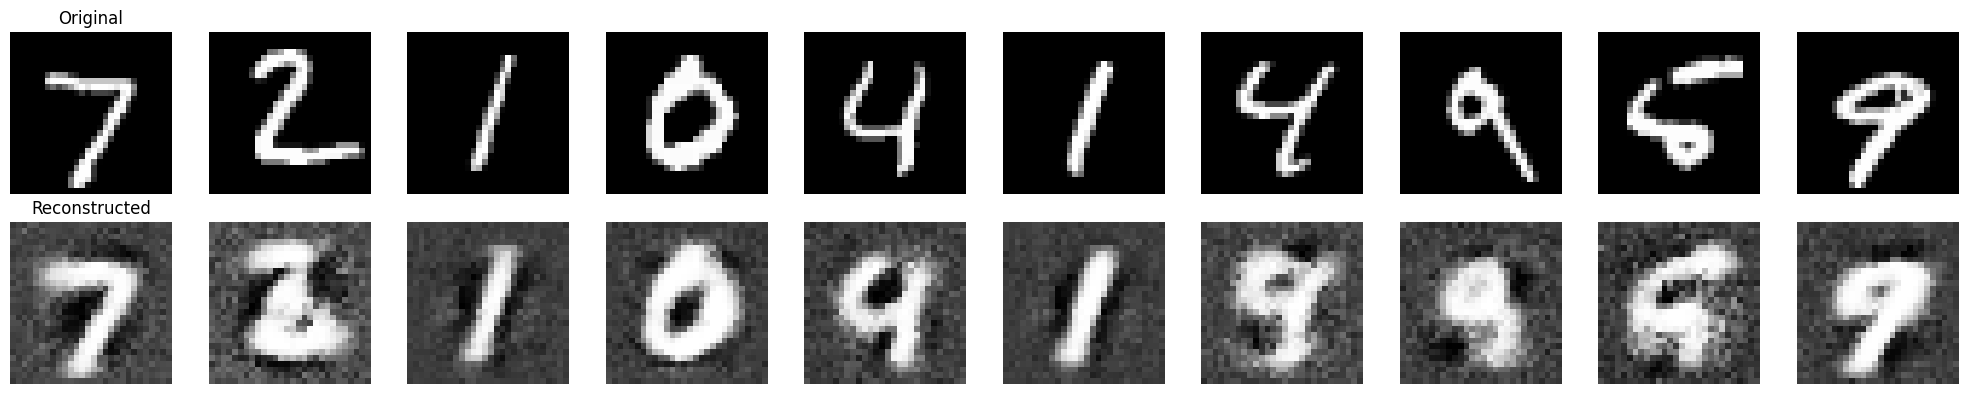


Epoch 1 metrics:
Train Loss: 0.5472
Train Contrastive Loss: 0.0039
Validation Loss: 0.4869
Validation Contrastive Loss: 0.1931



Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

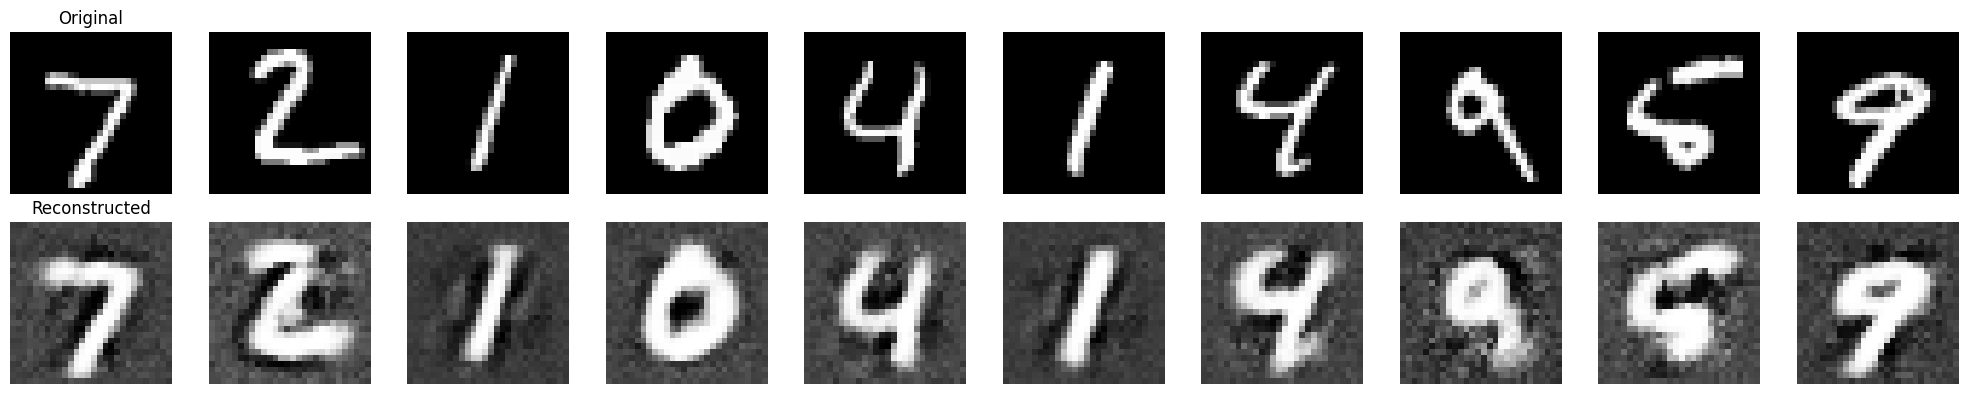


Epoch 2 metrics:
Train Loss: 0.4376
Train Contrastive Loss: 0.0060
Validation Loss: 0.4373
Validation Contrastive Loss: 0.1471



Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

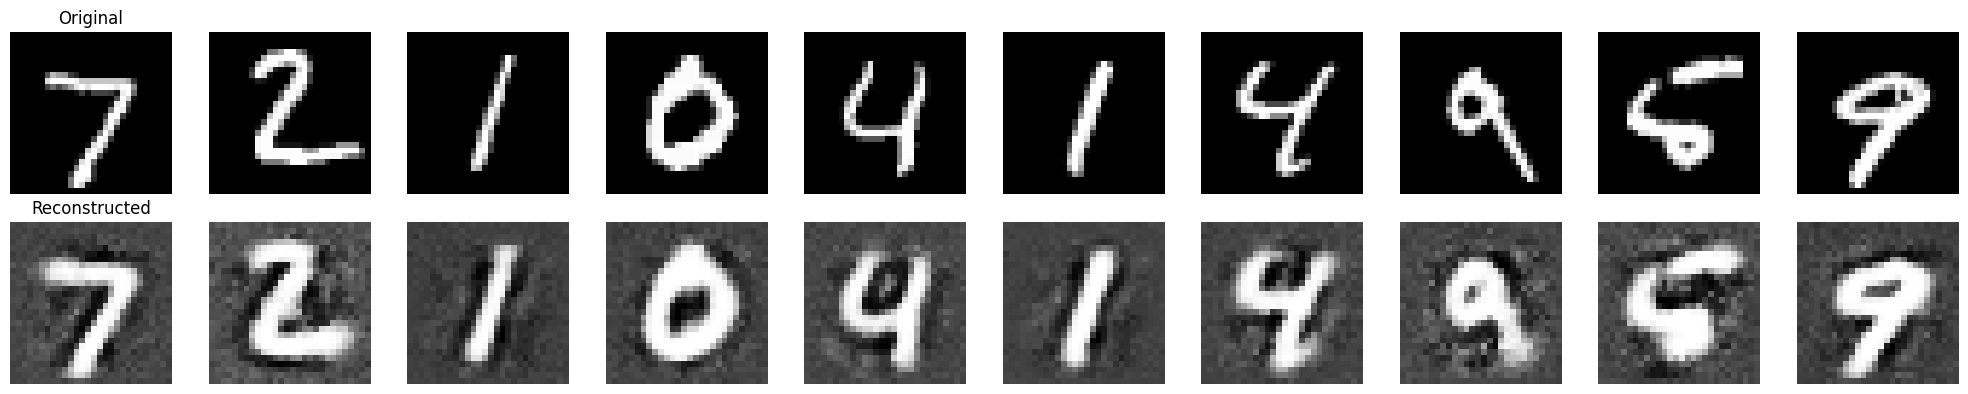


Epoch 3 metrics:
Train Loss: 0.4060
Train Contrastive Loss: 0.0025
Validation Loss: 0.4088
Validation Contrastive Loss: 0.0780



Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

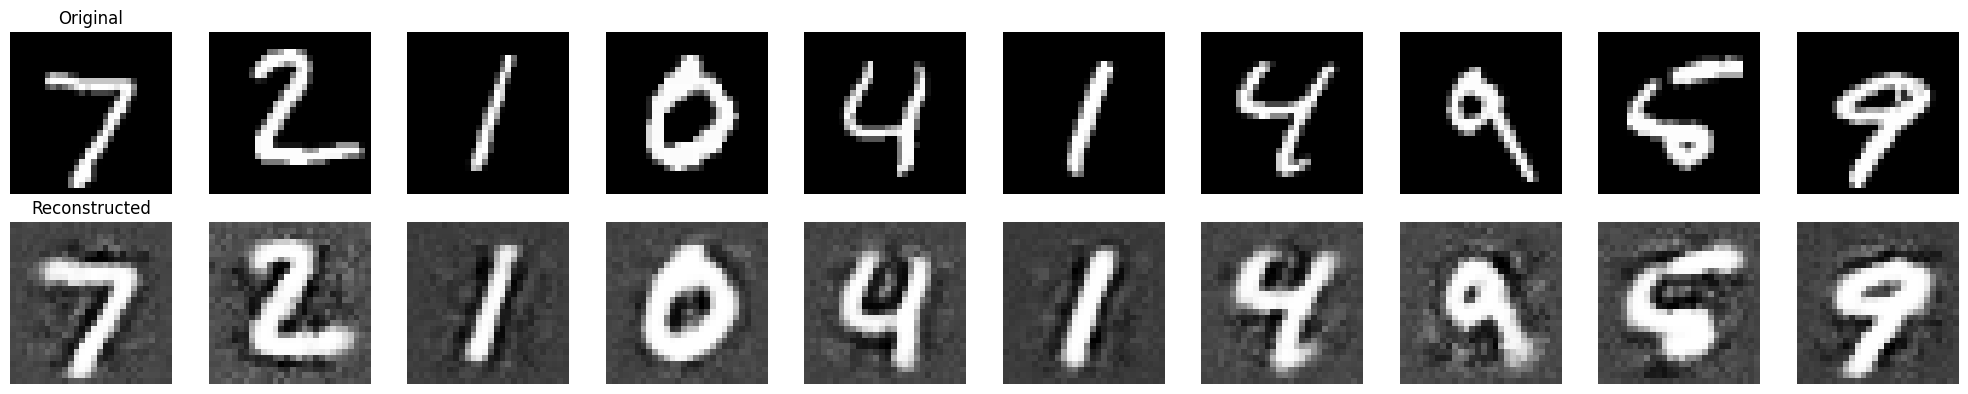


Epoch 4 metrics:
Train Loss: 0.3902
Train Contrastive Loss: 0.0074
Validation Loss: 0.3931
Validation Contrastive Loss: 0.0454



Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

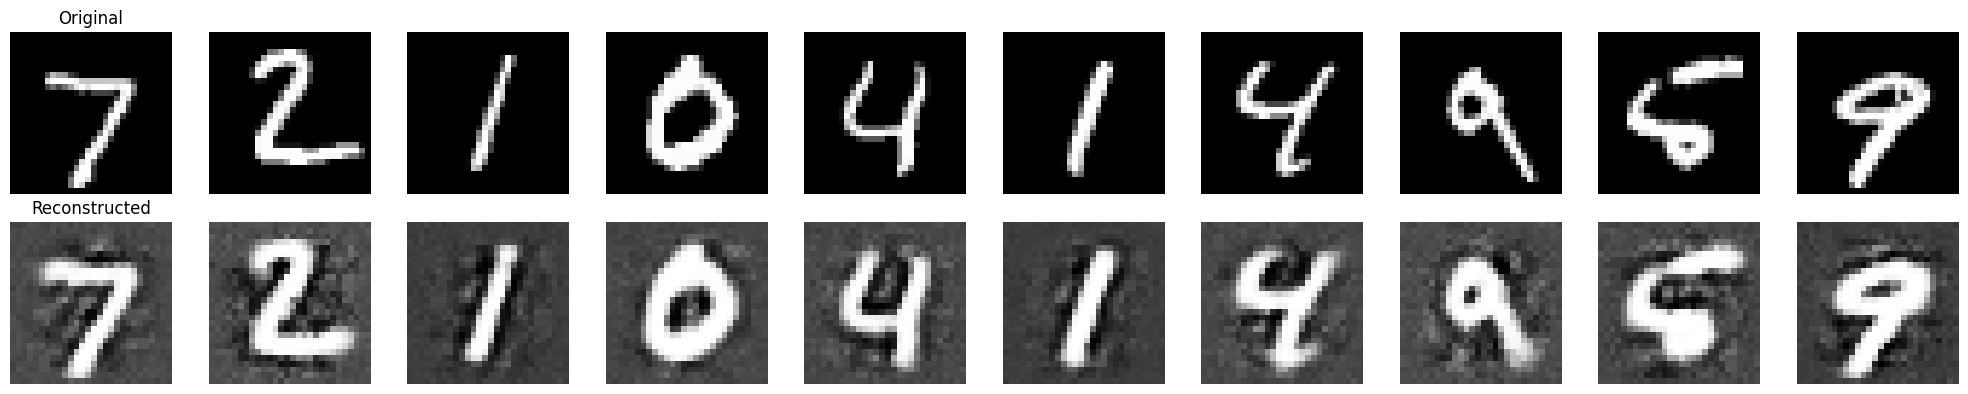


Epoch 5 metrics:
Train Loss: 0.3801
Train Contrastive Loss: 0.0067
Validation Loss: 0.3962
Validation Contrastive Loss: 0.1428



Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

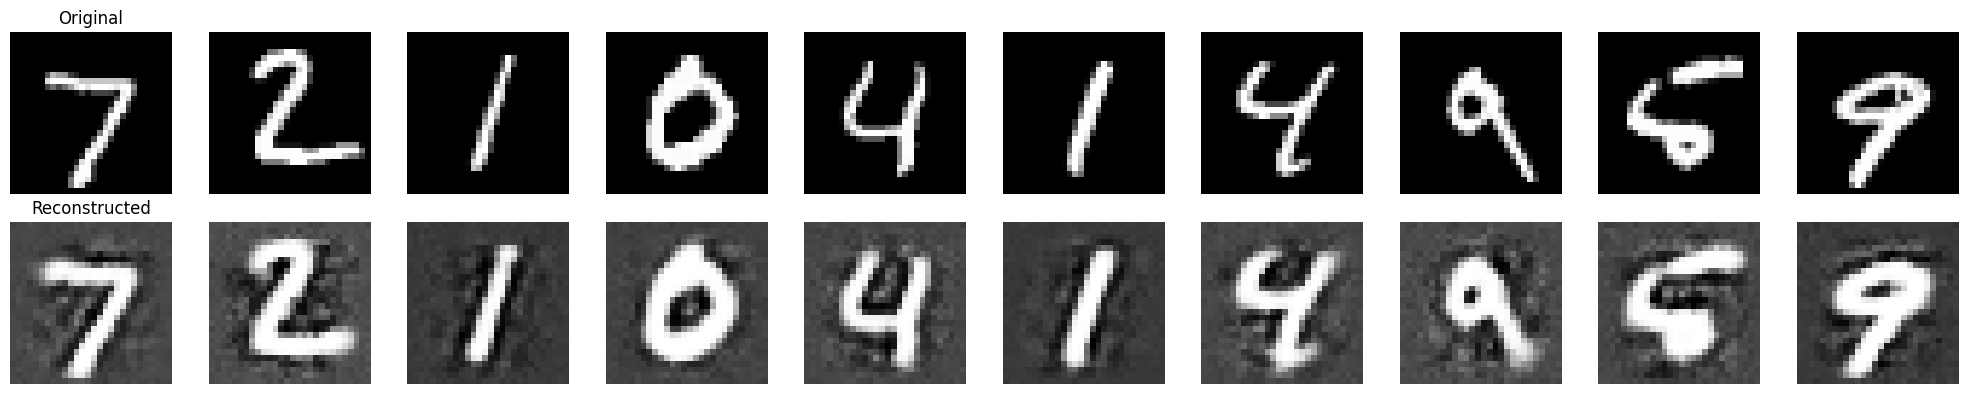


Epoch 6 metrics:
Train Loss: 0.3735
Train Contrastive Loss: 0.0049
Validation Loss: 0.3882
Validation Contrastive Loss: 0.1202



Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]

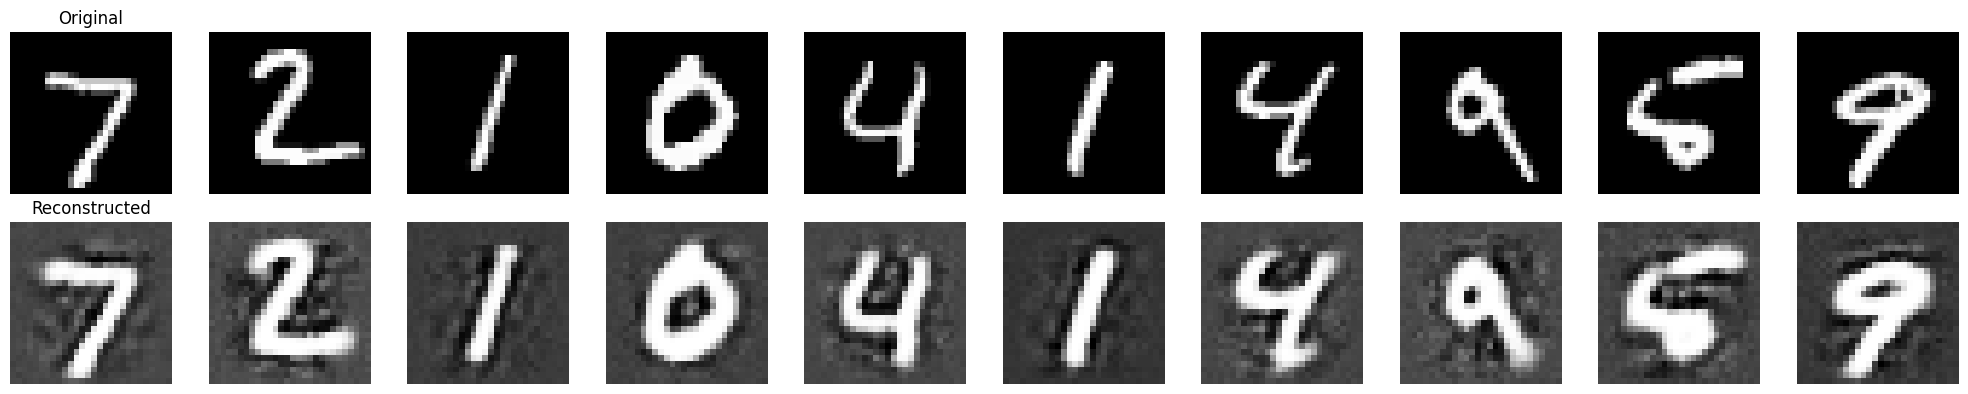


Epoch 7 metrics:
Train Loss: 0.3687
Train Contrastive Loss: 0.0038
Validation Loss: 0.3779
Validation Contrastive Loss: 0.0563



Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

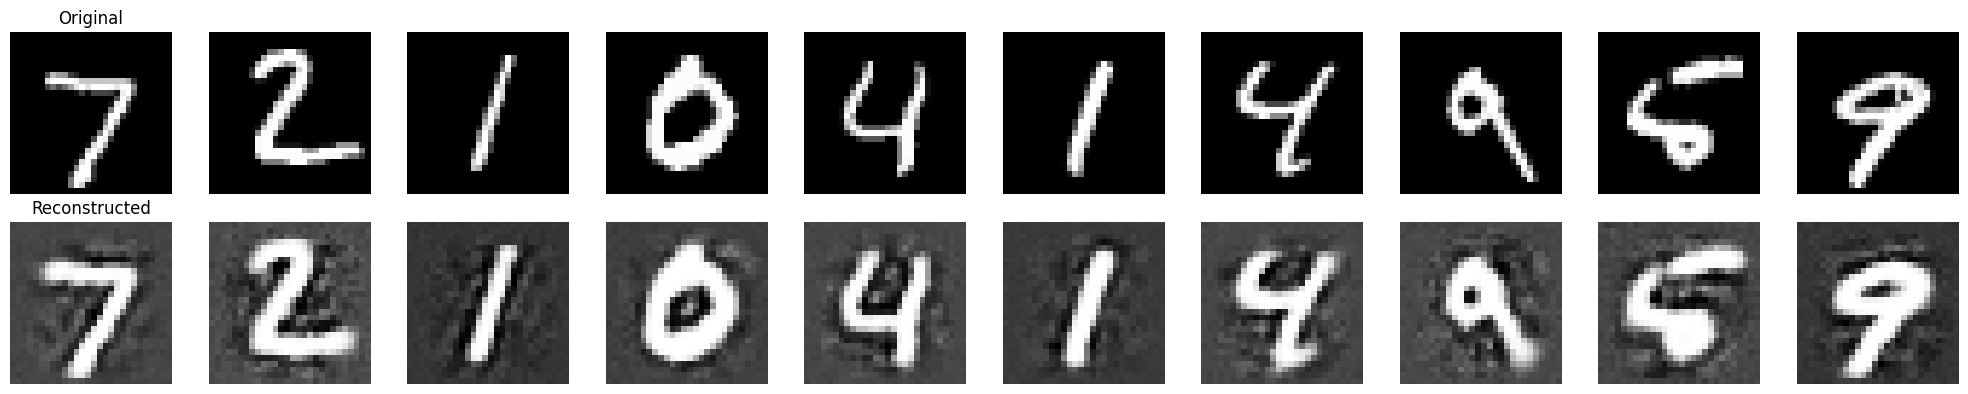


Epoch 8 metrics:
Train Loss: 0.3646
Train Contrastive Loss: 0.0013
Validation Loss: 0.3743
Validation Contrastive Loss: 0.0389



Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

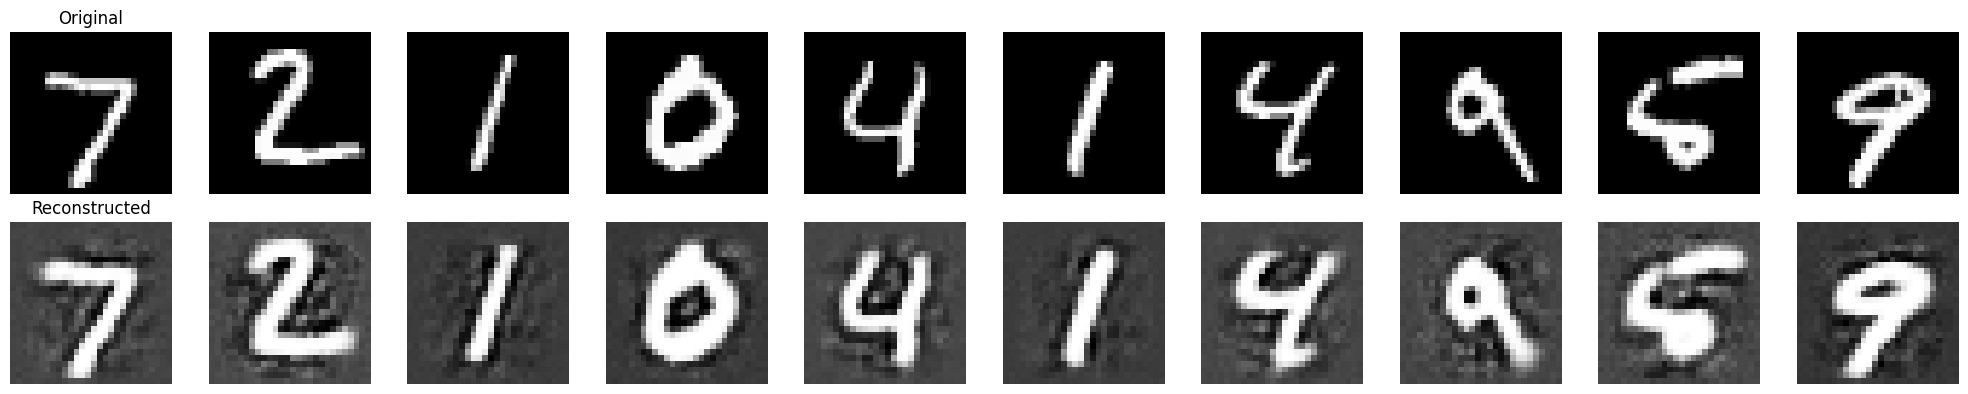


Epoch 9 metrics:
Train Loss: 0.3629
Train Contrastive Loss: 0.0061
Validation Loss: 0.3761
Validation Contrastive Loss: 0.0918



Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]

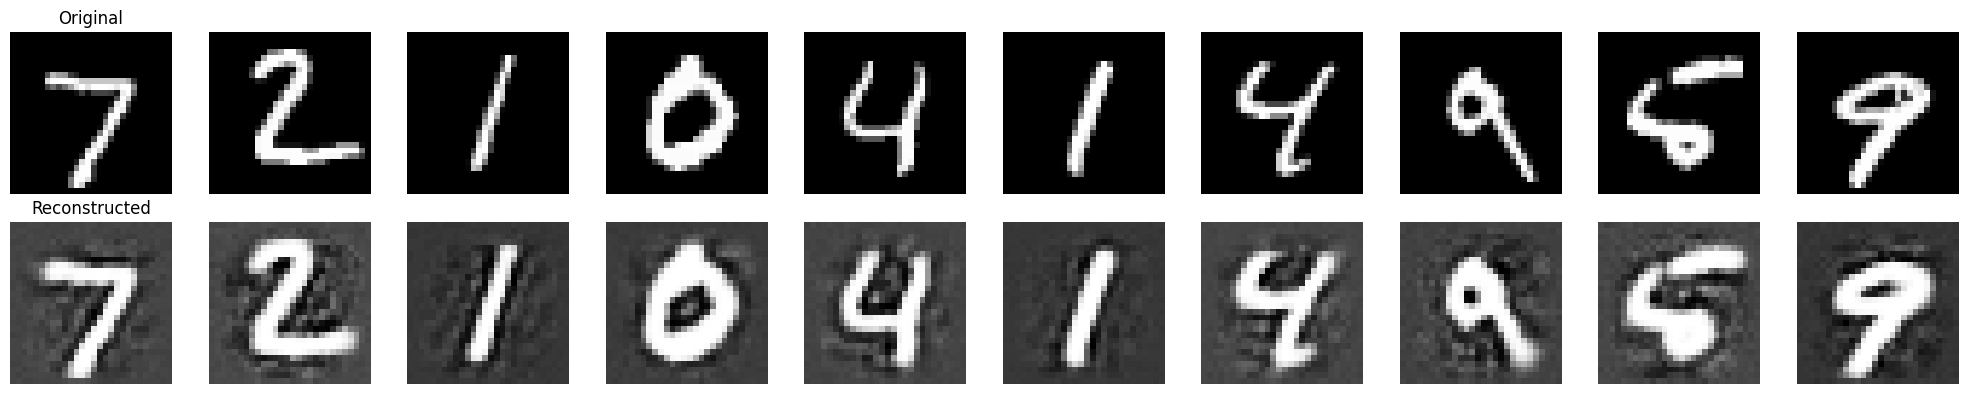


Epoch 10 metrics:
Train Loss: 0.3600
Train Contrastive Loss: 0.0041
Validation Loss: 0.3709
Validation Contrastive Loss: 0.0675



In [22]:
# Create HISOC model
input_dim = 28 * 28  # MNIST image size
hidden_dims = [512, 256, 128]  # Hierarchical dimensions
model = create_hisoc_model(input_dim, hidden_dims)

# Initialize trainer
trainer = HISOCTrainer(
    model=model,
    learning_rate=1e-4,
    batch_size=64,
    num_epochs=10,  # Start with 10 epochs for testing
    use_wandb=False
)

# Load data and start training
trainer.load_mnist_data()

# Training loop
for epoch in range(1, trainer.num_epochs + 1):
    # Train
    train_loss, train_contrastive = trainer.train_epoch(epoch)

    # Validate
    val_loss, val_contrastive, originals, reconstructions = trainer.validate()

    # Visualize reconstructions
    visualize_reconstructions(originals, reconstructions, epoch)

    # Print metrics
    print(f'\nEpoch {epoch} metrics:')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Train Contrastive Loss: {train_contrastive:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Contrastive Loss: {val_contrastive:.4f}\n')

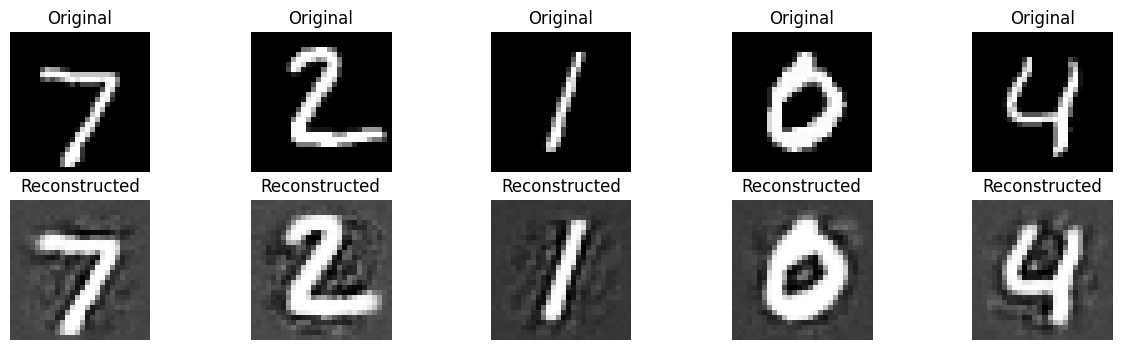

In [23]:
def evaluate_model_details(model, trainer):
    model.eval()
    with torch.no_grad():
        # Get a batch of validation data
        val_data, _ = next(iter(trainer.val_loader))
        val_data = val_data.view(val_data.size(0), -1).to(trainer.device)

        # Get model outputs
        outputs = model(val_data)

        # Visualize reconstructions
        reconstructions = outputs['reconstruction']

        # Plot original vs reconstructed images
        plt.figure(figsize=(15, 4))
        for i in range(5):
            # Original
            plt.subplot(2, 5, i + 1)
            plt.imshow(val_data[i].cpu().view(28, 28), cmap='gray')
            plt.title('Original')
            plt.axis('off')

            # Reconstruction
            plt.subplot(2, 5, i + 6)
            plt.imshow(reconstructions[i].cpu().view(28, 28), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')
        plt.show()

        return outputs

# Run evaluation
outputs = evaluate_model_details(model, trainer)

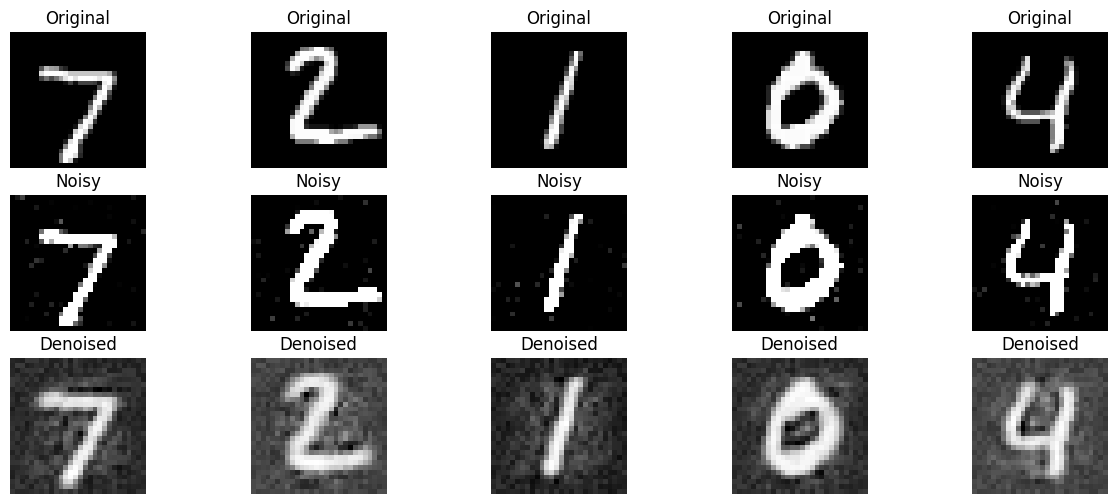

In [24]:
def test_denoising(model, trainer):
    model.eval()
    with torch.no_grad():
        # Get clean data
        val_data, _ = next(iter(trainer.val_loader))
        val_data = val_data.view(val_data.size(0), -1).to(trainer.device)

        # Add noise
        noisy_data = val_data + 0.25 * torch.randn_like(val_data)
        noisy_data = torch.clamp(noisy_data, 0, 1)

        # Reconstruct
        outputs = model(noisy_data)
        reconstructions = outputs['reconstruction']

        # Visualize
        plt.figure(figsize=(15, 6))
        for i in range(5):
            # Original
            plt.subplot(3, 5, i + 1)
            plt.imshow(val_data[i].cpu().view(28, 28), cmap='gray')
            plt.title('Original')
            plt.axis('off')

            # Noisy
            plt.subplot(3, 5, i + 6)
            plt.imshow(noisy_data[i].cpu().view(28, 28), cmap='gray')
            plt.title('Noisy')
            plt.axis('off')

            # Reconstructed
            plt.subplot(3, 5, i + 11)
            plt.imshow(reconstructions[i].cpu().view(28, 28), cmap='gray')
            plt.title('Denoised')
            plt.axis('off')
        plt.show()

# Test denoising
test_denoising(model, trainer)